# Home Credit Default Risk

참고 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook

# Introduce

## Data

고객이 대출금을 상환할 것인지 혹은 어려움을 겪을 것인지 예측하는 것은 중요한 사항이다. 다음과 같은 7가지 데이터소스가 있다.
- application_train/test : Home Credit의 대출 신청자에 대한 정보가 포함된 train, test 데이터. 모든 대출은 행이 있고 SK_ID_CURR 변수로 식별된다. 신청자의 train 데이터는 0(대출금 상환됨)과 1(대출금이 상환되지 않음)을 나타내는 TARGET이 있다.
- bureau : 고객의 다른 금융 기관의 이전 신용도 데이터. 각 이전 신용은 하나의 행이 있지만, 하나의 신청 데이터의 한 대출에 대해선 여러 개의 이전 신용 데이터가 있을 수 있다.
- bureau_balance : bureau의 이전 신용에 대한 월별 데이터. 각 행은 한 달간의 이전 신용이고, 하나의 이전 신용은 신용 기간에 따라 (월별) 여러 행을 가질 수 있다.
- previous_application : 신청 데이터에 대출이 있는 고객이 Home Credit에서 이전에 대출을 신청한 데이터. 신청 데이터의 각 현재 대출금엔 여러 개의 이전 대출금이 있을 수 있다. 각 이전 신청은 한 행을 가지며 SK_ID_PREV 변수에 의해 식별된다.
- POS_CASH_BALANCE : 이전 판매 시점이나 고객이 Home Credit에서 이전에 현금 대출한 시점에 대한 월별 데이터. 각 행은 이전의 판매나 현금 대출 시점에 대한 한 달이며, 각 이전 대출은 여러 행을 가질 수 있다.
- creadit_card_balance : 고객이 Home Credit에서 가지고 있던 이전 신용카드에 대한 월별 데이터. 각 행은 한 달간의 신용카드 잔액이고, 각 신용카드는 여러 행을 가질 수 있다.
- installments_payment : Home Credit에서 이전 대출금 결제 내역. 모든 결제된 건에 대해 한 행이 있고, 누락된 결제 건에 대해 한 행이 있다.

모든 데이터와 열에 대한 정의는 HomeCredit_columns_description.csv를 참고. 여기선 주요 train, test 데이터의 주요 신청만 사용한다. 

## Metric: ROC AUC

일단 데이터를 파악하면 제출시 점수가 판단되는 지표를 이해해야한다. 이 경우, ROC, AUC (Receiver Operating Characteristic Area Under the Curve, AUROC라고도 함)로 알려진 분류 지표다.<br><br>
ROC AUC는 두 가지 개별적인 개념을 이해할 수 있으면 비교적 간단하다. ROC 곡선은 true positive 비율과 false positive 비율을 그래프로 나타낸다.<br><br>
그래프의 선은 단일 모델의 곡선을 나타내고, 선의 움직임은 positive 인스턴스를 분류하는 데 사용되는 임계값이 변경되는 것을 나타낸다. 임계값은 우측 상단의 0으로 시작하고 좌측 하단의 1로 향한다. 좌측과 상단에 있을수록 더 좋은 모델이다. <br><br>
AUC(Area Under the Curve)는 그 이름에서 알 수 있듯 ROC 곡선 아래의 영역(곡선의 적분)이다. 0과 1 사이의 지표이며 더 나은 모델일수록 점수가 높다. 랜덤으로 단순 추측하는 모델은 ROC AUC가 0.5다.<br><br>
ROC AUC에 따라 분류기를 평가할 때, 0과 1 예측을 생성하는 것이 아니라 0과 1 사이 확률을 생성하는 것이다. 보통 정확도로 평가하는 것을 생각하지만, target이 불균형한 데이터에서 정확도는 최고의 지표가 아니다. (예시로, 100명 중 1명이 범인이면 모두 범인이 아니라고 하는 게 정확도가 99%임) ROC AUC가 모델 성능을 더 잘 나타낸다. 

# Read in Data

## Imports

In [1]:
# 데이터 조작
import numpy as np
import pandas as pd
# 범주형 변수 처리 
from sklearn.preprocessing import LabelEncoder
# 파일 시스템 관리
import os
# warnings 방지
import warnings
warnings.filterwarnings('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data

In [2]:
# 사용가능한 파일 나열
print(os.listdir('../input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# train 데이터
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape:', app_train.shape)
app_train.head()

Training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


train 데이터는 307511개의 관측치와 TRAGET을 포함한 122개의 변수가 있다.

In [4]:
# test 데이터 변수
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape:', app_test.shape)
app_test.head()

Testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


test 데이터셋이 크기가 더 작고 TARGET 열이 없다.

# Exploratory Data Analysis

EDA(Exploratory DAta Analysis)는 통계량을 계산하고 수치를 만들어 데이터의 추세, 이상징후, 패턴, 관계를 찾는 개방형 프로세스다. EDA의 목표는 데이터가 우리에게 말해줄 수 있는 걸 배우는 것이다. 일반적으로 높은 수준의 개요로 시작해 특정 영역으로 좁혀진다. 연구 결과는 그 자체로 흥미로울 수도 있고, 어떤 변수를 사용할지 결정할 수 있도록 도우며 모델 선택에 사용될 수 있다.

## Examine the Distribution of the Target Column

target은 예측해야할 것이다. 0은 제시기에 대출금이 상환되었다는 것을, 1은 고객이 대출금 지불에 어려움을 겪은 것을 나타낸다. 우선 각 범주에 속하는 대출 건수를 알아보자.

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

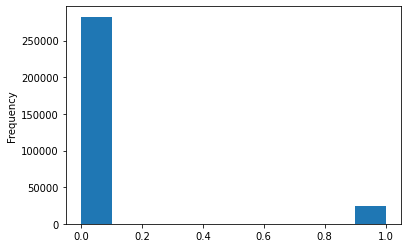

In [6]:
app_train['TARGET'].astype(int).plot.hist()

불균형 문제가 있다는 것을 알 수 있다. 상환되지 않은 대출금보다 상환된 대출금이 훨씬 많다. 더 정교한 기계학습 모델을 위해선 클래스(0,1)에 가중치를 부여해 불균형 문제를 해결할 수 있다.

## Examine missing values

각 열에서 결측값의 수와 비율을 알아보자.

In [15]:
# 열의 결측값을 계산하는 함수
def missing_values_table(df):
    mis_val = df.isnull().sum()  # 총 결측값 수
    mis_val_percent = 100*df.isnull().sum() / len(df)  # 결측값 비율
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  # 결과 테이블
    
    mis_val_table_ren_columns = mis_val_table.rename(      # 테이블 열 이름 변경
    columns = {0:'Missing Values', 1:'% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[      # 결측비율로 테이블
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(  # 내림차순 정렬
    '% of Total Values', ascending=False).round(1)
    
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'  # 요약
            'There are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    
    return mis_val_table_ren_columns  # 결측값 정보 데이터프레임 반환

In [16]:
# 결측값 통계량
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


기계학습 모델을 구축하려면 이러한 결측값을 대체해야한다(imputation이라고 함). 이후에, imputation 하지 않고 결측값을 처리할 수 있는 XGBoost와 같은 모델을 사용할 것이다. 결측값 비율이 높은 열을 삭제하는 방법도 있는데, 그 열이 모델에 유용할지 미리 알 수 없다. 따라서 일단 모든 열을 유지한다.

## Column Types

각 데이터타입의 열 수를 보자. int64와 float64는 (이산 혹은 연속형) 숫자 변수다. object 열은 문자열을 포함한 범주형 변수다.

In [17]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

각 object (범주형) 열의 고유한 범주 수를 알아보자.

In [21]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

대부분의 범주형 변수는 비교적 고유한 범주 수가 적다. 이런 범주형 변수를 다룰 방법을 찾아야한다.

## Encoding Categorical Variables

범주형 변수를 처리해야한다. 기계학습 모델은 범주형 변수를 처리할 수 없다(LightGBM과 같은 모델 제외). 따라서 이런 변수를 모델에 입력하기 전에 숫자로 인코딩하는 방법을 사용하는데, 다음과 같은 두 가지 방법이 있다.

- Label encoding : 범주형 변수의 각 고유한 범주를 정수로 할당해 새로운 열은 생성되지 않는다.
- One-hot encoding : 범주형 변수의 각 고유한 범주에 대해 새로운 열을 생성한다. 각 관측치는 해당 범주에 대한 열은 1로, 다른 모든 열은 0으로 표현된다.

label encoding의 문제는 범주에 임의적인 순서를 부여한다는 것이다. 각 범주에 할당된 정수값은 랜덤하고 범주의 고유한 측면을 반영하지 않는다. a=1, b=4로 label encoding을 하고 같은 과정을 반복하면 값이 달라질 수 있다. 범주형 변수의 고유한 범주가 두 개만 있다면(예: 성별) label encoding도 괜찮지만, 두 개 이상이면 one-hot encoding이 안전하다.

일부 모델은 label encoding된 범주형 변수를 문제 없이 처리할 수 있다. one-hot encoding의 단점은 범주 수가 많으면 변수의 수가 폭발적으로 증가할 수 있다는 것이다. 이걸 처리하기 위해 PCA나 다른 차원 축소 방법을 사용한 후 one-hot encoding을 적용해 차원 수를 축소할 수 있다.

여기선 범주가 2개인 범주형 변수에 대해 label encoding을 하고 범주가 2개 이상이면 one-hot encoding을 사용한다. (차원축소 또한 사용하지 않는다.)

### Label Encoding and One-hot Encoding

label encoding은 scikit-learn의 LabelEncoder를, one-hot encoding은 pandas의 get_dummies(df) 함수를 사용한다.

In [23]:
le = LabelEncoder()  # label encoder 객체 생성
le_count = 0

for col in app_train :  # 열 반복
    if app_train[col].dtype == 'object' :
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])  # train데이터 학습
            
            app_train[col] = le.transform(app_train[col])  # train데이터 변환
            app_test[col] = le.transform(app_test[col])  # test데이터 변환
            
            le_count += 1  # label encoding된 열의 수
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [24]:
# 범주형 변수 one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 243)
Testing Features shape : (48744, 239)


### Aligning Training and Testing Data

train, test 데이터에 모두 같은 변수가 있어야한다. one-hot encoding은 test 데이터에 범주가 표시되지 않는 일부 범주형 변수가 있어 train 데이터가 더 많은 열을 생성했다. test 데이터에 없는 train 데이터의 열을 제거하려면 데이터프레임을 정렬해야한다. 먼저 train 데이터에서 target 열을 추출한다. 정렬할 땐 행이 아닌 열 기준으로 데이터프레임을 정렬하도록 axis=1로 설정해야한다.

In [26]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join='inner', axis=1)  # 둘다 있는 열만 유지하며 정렬
app_train['TARGET'] = train_labels  # target 다시 추가 (위 작업에서 target 빠짐)

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 240)
Testing Features shape : (48744, 239)


이제 train, test 데이터셋은 기계학습에 필요한 같은 변수를 갖는다. one-hot encoding으로 인해 변수의 수가 상당히 많아졌다. 어느 시점에 데이터셋의 크기를 줄이기 위해 차원축소(관련 없는 변수 제거)를 시도할 수도 있다.

## Back to EDA

### Anomalies (이상치)

EDA를 진행할 때 데이터의 이상치를 주의해야한다. 잘못 입력된 숫자, 측정 장비 오류, 극단적 측정 때문일 수 있다. 이상치는 describe 메소드를 사용해 열의 통계량으로 볼 수 있다. DAYS_BIRTH 열의 숫자는 현재 대출 신청과 관련된 기록이므로 음수다. 연도별 통계를 보려면 -1을 곱하고 1년의 날짜 수(365)로 나눈다.

In [27]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

나이대가 적당해보인다. 최대값과 최소값에서 나이의 이상치가 없다. 입사일도 살펴보자.

In [30]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

올바르지 않아보인다. 최대값은 약 1000년이다.

Text(0.5, 0, 'Days Employment')

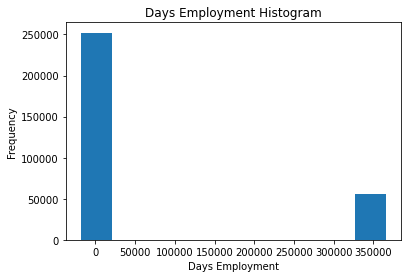

In [31]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

이상치인 고객을 세분화해서 다른 고객보다 채무불이행률이 더 높은지 낮은지 알아보자.